## Experiment_Pipeline

In [1]:
import os
import sys
import yaml
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%pip install wandb -qU
%matplotlib inline

# Get the current working directory
notebook_dir = notebook_dir = os.path.dirname(os.path.abspath("__file__"))  
project_dir = os.path.abspath(os.path.join(notebook_dir, '..')) 
if project_dir not in sys.path:
    sys.path.append(project_dir)

from src import (get_transforms, load_data, split_data, set_seeds, 
                 verify_splits, verify_data, plot_species_grid,
                 verify_loader_transforms)
from src.data_utils import ImagesDataset
from src.data_utils import validation_block_and_resize
from src.models import build_resnet50_basic
from src.train import setup_training, evaluate, train

Note: you may need to restart the kernel to use updated packages.


Ensure your directory is set up properly:

In [2]:
!tree ../ -L 2


../
├── LICENSE
├── README.md
├── configs
│   ├── default_cuda.yaml
│   ├── default_mps.yaml
│   ├── effnetV2_focal_exp.yaml
│   ├── effnet_exp.yaml
│   └── loss_exp.yaml
├── data
│   └── givens
├── environment.yml
├── notebooks
│   ├── Exp_Focal_V2_Efficientnet.ipynb
│   ├── ExperimentResNet_GradCam.ipynb
│   ├── Experiment_Balance_Classes.ipynb
│   ├── Experiment_Pipeline.ipynb
│   └── wandb
├── src
│   ├── __init__.py
│   ├── __pycache__
│   ├── data_utils.py
│   ├── focal_loss.py
│   ├── models.py
│   ├── train.py
│   └── utils.py
└── wildlife_env.yaml

8 directories, 19 files


In [3]:
!tree ../data/ -L 2

../data/
└── givens
    ├── benchmark.ipynb
    ├── submission_format.csv
    ├── test_features
    ├── test_features.csv
    ├── train_features
    ├── train_features.csv
    └── train_labels.csv

4 directories, 5 files


### **Set up your experiment**

Copy this notebook. Rename it, but keep it in `notebooks/`. To update any settings, params, and/or hyperparams make a copy of `configs/default.yaml`, rename it and call your new `.yaml` below. Be sure to keep it in `configs/`

In [4]:
# Locate the YAML file relative to the notebook's location
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# You need to update this path to your new .yaml file
config_path = os.path.join(notebook_dir, "../configs/default_mps.yaml")

# Load the YAML file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [5]:
print(torch.__version__)
print(torch.backends.mps.is_available())
device = config["device"]

2.2.2
True


### **Build the datasets**

#### Load the data
Note: your data file should be hidden in the repo (.gitignore) but make sure to set it up locally like:

`wildlife/data/givens/test_features/[images...]`

`wildlife/data/givens/train_features/[images...]`

`wildlife/data/givens/train_features.csv`

`wildlife/data/givens/test_features.csv`

In [6]:

train_features, test_features, train_labels, species_labels = load_data()

#### Augment Data

In [7]:
# Get transforms
train_transforms, val_transforms = get_transforms(config)
print(val_transforms)

Compose(
    Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
    Lambda()
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


#### Split into train and evaluation sets

We need to ensure that sites are mutually exclusive between the training and validation sets, meaning no site should appear in both sets. This ensures a proper stratification based on site.

In [8]:
set_seeds(config["experiment"]["seed"])
X_train, X_val, y_train, y_val = split_data(
    train_features, train_labels, type='sites')

In [9]:
# Helper function (Optional)
# verify_splits(X_train, y_train, X_val,  y_val)

#### Set up DataLoader

In [9]:
set_seeds(config["experiment"]["seed"])

# Create datasets
train_dataset = ImagesDataset(
    features=X_train, 
    labels=y_train, 
    transform=train_transforms, 
    device=device)
val_dataset = ImagesDataset(
    features=X_val, 
    labels=y_val, 
    transform=val_transforms, 
    device=device)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=True, pin_memory=True)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=False, pin_memory=True)

In [11]:
# verify transformations in dataloaders (Optional)
# verify_loader_transforms(train_loader, title_type='train')
# verify_loader_transforms(val_loader, title_type='validate')

# set_seeds(config["experiment"]['seed'])

In [10]:
# Print shapes for verification (Optional)
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Training set: 13171 samples
Validation set: 3317 samples


### **Training**


#### Define the model
Note: If you build a new model, add it to `models.py` and update the block below. And update your `.yaml` config.

In [11]:
set_seeds(config["experiment"]['seed'])
model = build_resnet50_basic(
    num_classes = config["model"]["num_classes"],
    hidden_units1 = config["model"]["hidden_units1"],
    dropout = config["model"]["dropout"] 
)
model = model.to(device)

#### Define your criterion and optimizer
Note: If needed up date these in `train.py` and update your `.yaml` config.

In [12]:
set_seeds(config["experiment"]['seed'])
criterion, optimizer = setup_training(
        model, 
        criterion=config["train"]["criterion"],
        optimizer=config["train"]["optimizer"], 
        lr=config["train"]["lr"], 
        momentum=config["train"]["momentum"])

#### Set up logging

In [14]:
wandb.require()
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zachary-thomas-abraham (zachary-thomas-abraham-n-a). Use `wandb login --relogin` to force relogin


True

In [15]:
# ✨ W&B: Initialize a new run to track this model's training
wandb.init(project="wildlife", config=config)

#### Run the train / eval loop

In [16]:
train_losses = []  # To store average training loss per epoch
val_losses = []    # To store validation loss per epoch
set_seeds(config["experiment"]['seed'])

start_time = time.time()
for epoch in range(config["train"]["epochs"]):
    # Training step
    avg_train_loss = train(model, 
                                     train_loader, 
                                     criterion, 
                                     optimizer, 
                                     epoch, config, device=device)
    train_losses.append(avg_train_loss)  # Store avg training loss
    print(f"Epoch {epoch+1}/{config['train']['epochs']} - Avg Train Loss: {avg_train_loss:.12f}")
    
    # Evaluation step
    eval_metrics = evaluate(model, val_loader, criterion, config, epoch+1, device=device)
    val_losses.append(eval_metrics["loss"])  # Store validation loss
    print(f"Epoch {epoch+1}/{config['train']['epochs']} - Eval Loss: {eval_metrics['loss']:.12f}, Eval Acc: {eval_metrics['accuracy']:.2f}%")

end_time = time.time()
duration = end_time - start_time
wandb.log({"duration": duration})


Starting training for epoch 1
Epoch [1/2], Step [100/412], Loss: 1.509845614433
Epoch [1/2], Step [200/412], Loss: 1.413497328758
Epoch [1/2], Step [300/412], Loss: 0.913659155369
Epoch [1/2], Step [400/412], Loss: 0.771535456181
Epoch 1/2 - Avg Train Loss: 1.137719550251
Eval - Loss: 1.6634, Accuracy: 41.78%, Precision: 0.42, Recall: 0.42, F1: 0.40, MacroF1: 0.40
Epoch 1/2 - Eval Loss: 1.663389899410, Eval Acc: 41.78%
Starting training for epoch 2
Epoch [2/2], Step [100/412], Loss: 0.762128949165
Epoch [2/2], Step [200/412], Loss: 0.763661503792
Epoch [2/2], Step [300/412], Loss: 0.893061697483
Epoch [2/2], Step [400/412], Loss: 0.411080837250
Epoch 2/2 - Avg Train Loss: 0.734514706777
Eval - Loss: 1.5132, Accuracy: 47.54%, Precision: 0.52, Recall: 0.48, F1: 0.47, MacroF1: 0.46
Epoch 2/2 - Eval Loss: 1.513223670423, Eval Acc: 47.54%


If you are done logging or you want to run the experiment again, finish with the block below. But if you think you might want to submit this run to the competition, don't finish logging until the end once you've added the competition score.

In [17]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

duration,▁
epoch,▁▁▁▁▁▁▁▁████████
eval_accuracy,▁█
eval_f1,▁█
eval_loss,█▁
eval_macro_f1,▁█
eval_precision,▁█
eval_recall,▁█
f1_antelope_duiker,▁█
f1_bird,█▁
f1_blank,▁█


---


### **Explore Experiment** 

In [18]:
# set to True to explore and potentially submit your results 
explore = False

Grad Cam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Grad CAM')

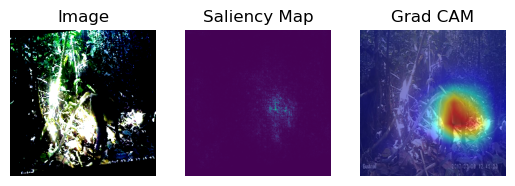

In [36]:
from PIL import Image
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from src import data_utils
import cv2
import numpy as np
from matplotlib.pyplot import imshow

target_layers = [model.layer4[-1]]

img_path = os.path.join(notebook_dir, "../data/givens/test_features/ZJ020875.jpg")
img = Image.open(img_path)
input_tensora = train_transforms(img).to("mps")
input_tensor = input_tensora.unsqueeze(0)
targets = None


cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

#print(grayscale_cam.shape) 
#print(grayscale_cam.dtype)
input_image = img.resize((224, 224))
visualization = show_cam_on_image(np.array(input_image)/255.0, grayscale_cam, use_rgb=True)


img = Image.fromarray(visualization)

model.eval()
input_tensor.requires_grad = True  
output = model(input_tensor)  
class_score = output[0].max()
model.zero_grad()  
class_score.backward()  
    
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)

saliency_map = saliency.squeeze().cpu().numpy()

plt.subplot(1, 3, 1)
plt.imshow(input_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
plt.axis('off')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map)
plt.axis('off')
plt.title('Saliency Map')

plt.subplot(1, 3, 3)
plt.imshow(img)
plt.axis('off')
plt.title('Grad CAM')



#### Learning Curve

In [40]:
if explore:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, config["train"]["epochs"]+1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, config["train"]["epochs"]+1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Batch Loss During Training

In [ ]:
#not active in current version of train(), look at comments in train()

# if explore:
#     # Convert tracking_loss to a pandas Series for convenient rolling average
#     tracking_loss_series = pd.Series(tracking_loss_all)

#     # Plot
#     plt.figure(figsize=(10, 5))
#     tracking_loss_series.plot(alpha=0.2, label="Batch Loss")
#     tracking_loss_series.rolling(center=True, min_periods=1, window=10).mean().plot(
#         label="Loss (Moving Avg)", linewidth=2
#     )
#     plt.xlabel("(Epoch, Batch)")
#     plt.ylabel("Loss")
#     plt.title("Batch Loss During Training")
#     plt.legend(loc="upper right")
#     plt.show()

#### Class Distribution  

True Labels from Training Set

In [22]:
if explore:
    print("True labels (training):")
    print(y_train.idxmax(axis=1).value_counts())   

True and Predicated Labels from Validation Set

In [23]:
if explore:
    # Extract predictions and true labels from eval_metrics
    all_preds = eval_metrics["all_preds"]
    all_labels = eval_metrics["all_labels"]

    # Convert all_preds to DataFrame and map to class names
    preds_df = pd.DataFrame(all_preds, columns=["predicted_class"])
    preds_df["predicted_label"] = preds_df["predicted_class"].map(
        lambda idx: species_labels[idx]
    )

    # Convert all_labels to DataFrame and map to class names
    labels_df = pd.DataFrame(all_labels, columns=["true_class"])
    labels_df["true_label"] = labels_df["true_class"].map(
        lambda idx: species_labels[idx]
    )

    # Combine predictions and true labels for analysis
    results_df = pd.concat([preds_df, labels_df], axis=1)

    # Display value counts for predicted and true labels
    print("Predicted labels (eval):")
    print(results_df["predicted_label"].value_counts())

    print("\nTrue labels (eval):")
    print(results_df["true_label"].value_counts())

Accuracy per class

In [24]:
if explore:    
    per_class_accuracy = results_df.groupby("true_label").apply(
        lambda x: (x["true_label"] == x["predicted_label"]).mean(), 
    )
    print("Per-Class Accuracy:")
    print(per_class_accuracy)

Confusion Matrix

In [25]:
if explore:
    from sklearn.metrics import ConfusionMatrixDisplay

    eval_true = pd.Series(all_labels).apply(lambda x: species_labels[x])
    eval_predictions = pd.Series(all_preds).apply(lambda x: species_labels[x])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = ConfusionMatrixDisplay.from_predictions(
        eval_true,
        eval_predictions,
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        normalize='true'
    )
    plt.title("Normalized Confusion Matrix")
    plt.show()

### **Create Submission**

### Set up Datatloader

In [26]:
if explore:
    set_seeds(config["experiment"]["seed"])
    test_dataset = ImagesDataset(
        test_features, 
        transform=val_transforms, 
        device=device)

    test_loader = DataLoader(
        test_dataset, 
        batch_size=config["train"]["batch_size"], 
        shuffle=False, pin_memory=True)
    
    print(f"Test set: {len(test_dataset)} samples")

### Test Model

In [27]:
if explore:
    test_preds_collector = []

    # put the model in eval mode so we don't update any parameters
    model.eval()

    # we aren't updating our weights so no need to calculate gradients
    with torch.no_grad():
        for batch_n, batch in enumerate(test_loader):
            # run the forward step
            images = batch["image"].to(device)
            logits = model(images)

            # apply softmax so that model outputs are in range [0,1]
            preds = F.softmax(logits, dim=1)

            # store this batch's predictions in df
            # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
            preds_df = pd.DataFrame(
                preds.cpu().numpy(),
                index=batch["image_id"],
                columns=species_labels,
            )
            test_preds_collector.append(preds_df)

    submission_df = pd.concat(test_preds_collector)

Create your submission. Update submission_number.

Make sure your directory is properly set up, as both `/data` and `/results` are ignored by the repo.

In [28]:
if explore:
    submission_number=11
    submission_df.index.name = 'id'
    submission_df = submission_df.round(6)
    submission_format_path = "../data/givens/submission_format.csv"
    submission_format = pd.read_csv(submission_format_path, index_col="id")


    assert all(submission_df.index == submission_format.index)
    assert all(submission_df.columns == submission_format.columns)

    # Save submission_df for further use
    submission_df_path = f"../results/submissions/submission{submission_number}.csv"
    submission_df.to_csv(submission_df_path)

After you submit update the submission score for logging.

In [29]:
if explore:
     # ✨ Mannualy Log Test Results to W&B
    wandb.log({
        "test_score": 1.4578
    })

End your logging session.

In [30]:
if explore:
    # ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
    wandb.finish()